In [18]:
from transformers import ResNetConfig,ResNetModel,BertTokenizer,Trainer,TrainingArguments
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import pickle
import evaluate
import numpy as np

In [2]:
# tokenizer
tokenizer = BertTokenizer('./vocab.txt',)
# encoder
config_encoder = ResNetConfig()
model_encoder = ResNetModel(config=config_encoder)
# decoder
model_decoder = nn.Transformer(batch_first=True)

In [3]:
# 测试 tokenizer
test_caption = 'Krxk is a great developer.'
t = tokenizer.encode(test_caption,return_tensors='pt')
t = t.repeat((2, 1))
print(t)
print(t.shape)

tensor([[ 101,  180, 1197, 1775, 1377, 1110,  170, 1632, 9991,  119,  102],
        [ 101,  180, 1197, 1775, 1377, 1110,  170, 1632, 9991,  119,  102]])
torch.Size([2, 11])


In [4]:
# 加载 caption
# 纯数学公式
save_cwd = os.getcwd()

root_dir = 'F:/DP-Dataset/dataset-formula/'
os.chdir(root_dir)
train_dir = root_dir + 'train'
val_dir = root_dir + 'dev'

out_path_mid = root_dir.split('/')[-2].replace('dataset-', '') + '_'

with open(out_path_mid + 'train_out', 'rb') as f:
    train_labels = pickle.load(f)
    
with open(out_path_mid + 'dev_out', 'rb') as f:
    val_labels = pickle.load(f)
    
with open(out_path_mid + 'test_out', 'rb') as f:
    test_labels = pickle.load(f)
    
os.chdir(save_cwd)

In [5]:
# train_labels, val_labels

In [6]:
# 用于整合 Image 与 Caption，构造 Image-Caption 数据集，同时预先对label进行tokenize(tokenize后为二维，压缩0维)
class Compose_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, image_dataset, caption_list, tokenizer):
        super().__init__()
        self.image_dataset = image_dataset
        self.caption_list = caption_list
        self.imgs = image_dataset.imgs
        self.tokenizer = tokenizer
    def __getitem__(self, idx):
        index = self.caption_list['id'].index(self.imgs[idx][0].split('\\')[-1].replace('png', 'txt'))
        return {'X':self.image_dataset[idx][0], 'labels':self.tokenizer.encode(
            self.caption_list['label'][index], padding='max_length', truncation=True, max_length=80, return_tensors='pt').squeeze()}
    def __len__(self):
        return len(self.image_dataset)

In [7]:
pic_dir = 'F:/DP-Dataset/s'
data_args = transforms.Compose([
    transforms.Pad([200, 200]), # 填充
    transforms.Resize((200,200), interpolation=Image.Resampling.BICUBIC), # 调整为正方形并统一大小
    transforms.ToTensor()
])
data_set = datasets.ImageFolder(pic_dir, transform=data_args)

with open('F://DP-Dataset//s/formula_dev_out', 'rb') as f: # 打开格式化后的caption二进制文件
    label_list = pickle.load(f)
compose_dataset = Compose_Dataset(data_set, label_list, tokenizer)

batch_size = 32
data_iter = torch.utils.data.DataLoader(compose_dataset, batch_size=batch_size, shuffle=True)

C:\Users\12469\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


torch.Size([2, 3, 200, 200])
tensor([ 101,  165, 1286,  165,  196,  165, 3295,  196, 9245,  198,  196,  181,
         198,  193,  168,  196,  122,  198,  133,  193,  168,  196,  123,  198,
         165,  165,  175,  165, 1286,  113,  193,  168,  196,  122,  198,  165,
        1268,  114,  133,  175,  165, 1286,  113,  193,  168,  196,  123,  198,
         165, 1268,  114,  165, 1322,  196, 9245,  198,  165, 1268,  119,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


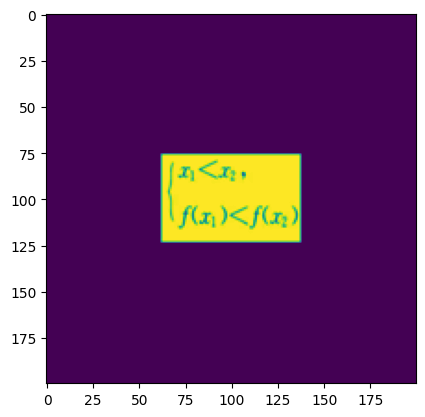

In [24]:
# 测试数据集
import matplotlib.pyplot as plt
for dic in data_iter:
    X = dic['X']
    label = dic['labels']
    # X 是一个 batch
    print(X.shape)
    test_id = 0
    print(label[test_id])
    plt.imshow(X[test_id][0]) # 查看 R 通道
    break

In [9]:
# model
def Loss(src, tgt):
    return F.cross_entropy(src, tgt)

class Krxk_model(nn.Module):
    def __init__(self, tokenizer, encoder, decoder):
        super().__init__()
        self.tokenizer = tokenizer
        self.encoder = encoder
        self.embed_size = self.tokenizer.vocab_size
        self.transformer_encoder_in_nums = 512
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048 * 7 * 7, self.transformer_encoder_in_nums)) # 将 resnet 转化为 全连接
        self.embed = nn.Embedding(self.embed_size, self.transformer_encoder_in_nums) # 嵌入为 transformer的in_features维度
        self.decoder = decoder
        
        # 用作临时 caption 测试案例
#         test_caption = 'Krxk is a great developer.' 
#         print(test_caption)
#         self.test_caption_tokenized = self.tokenizer.encode(test_caption, return_tensors='pt').repeat(6, 1) # 临时案例中有6张图片
#         print(self.test_caption_tokenized.shape)
#         print(self.embed(self.test_caption_tokenized).shape)
        
    def forward(self, X, labels):
        encode = self.encoder(X).last_hidden_state
        features = self.fc(encode) # 将图片特征映射为词表特征
        
        # 此处将 embeddings 与 resnet 提取的特征进行concat 输入 transformer
#         embeddings = torch.concat((embeddings, embeddings), dim=1)
        embeddings = self.embed(labels)
        f = features.unsqueeze(1)
#         print(embeddings.shape, f.shape)
        embeddings_attach = torch.concat((embeddings, features.unsqueeze(1)), dim=1)

        # decode 需要输入 src 与 tgt，分别用作 Transformer 编码器与解码器（输入正确的caption）的输入
        decode = self.decoder(embeddings_attach, embeddings)
        return Loss(embeddings,decode),decode # 损失放在第一返回位置

In [10]:
# 定义 model
model = Krxk_model(tokenizer ,model_encoder, model_decoder)

In [11]:
# # 图片测试
# pic_dir = './pic/'
# data_args = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor()
# ])
# data_set = datasets.ImageFolder(pic_dir, transform=data_args)
# batch_size = 32
# data_iter = torch.utils.data.DataLoader(data_set, batch_size=batch_size)

In [12]:
# 模型测试
model.eval() # 评估模式运行减少计算量
for dic in data_iter:
    X = dic['X']
    label = dic['labels']
    print(X.shape)
    print(label.shape)
    l, generated_ids = model.forward(X, label)
    print(l, generated_ids.shape)
    break

torch.Size([2, 3, 200, 200])
torch.Size([2, 80])
tensor(-2.7705, grad_fn=<DivBackward1>) torch.Size([2, 80, 512])


In [19]:
# 计算 metric
assess_path = 'F:/DEVELOP/Machine-Learning/SRP/evaluate/metrics/accuracy/accuracy.py'
accuracy = evaluate.load(assess_path)
def compute_metrics(eval_pred): # 修改此处
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
# 训练参数
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch', learning_rate=5e-3, 
                                    load_best_model_at_end=True, num_train_epochs=5, use_cpu=True) # 暂时采用CPU
trainer = Trainer(model, args=training_args, train_dataset=compose_dataset, eval_dataset=compose_dataset, compute_metrics=None) # 修改数据集

In [23]:
%%time
# 训练
trainer.train(resume_from_checkpoint=False)

Epoch,Training Loss,Validation Loss
1,No log,-33.175125
2,No log,-36.971756
3,No log,-39.589691
4,No log,-41.063450
5,No log,-41.779083


Wall time: 2min 7s


TrainOutput(global_step=5, training_loss=-35.177740478515624, metrics={'train_runtime': 127.7952, 'train_samples_per_second': 0.078, 'train_steps_per_second': 0.039, 'total_flos': 0.0, 'train_loss': -35.177740478515624, 'epoch': 5.0})